In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import halfnorm

In [ ]:
def half_normal(d, scale):
    """Half-normal detection function."""
    return halfnorm.pdf(d, scale=scale) / halfnorm.pdf(0, scale=scale)

def compute_distances(xs, ys, grid_x, grid_y):
    """Compute distance from each grid point to each recorder."""
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    n_recorders = len(xs)
    distances = np.zeros((*X.shape, n_recorders))
    for i, (x, y) in enumerate(zip(xs, ys)):
        distances[..., i] = np.sqrt((X - x)**2 + (Y - y)**2)
    return distances

def calculate_probs(det_func, distances):
    """Apply detection function to distances for each recorder."""
    return det_func(distances)

def detection_probabilities(probs, min_detectors=4):

    from scipy.special import comb

    n_recorders = probs.shape[-1]
    prob_detect_k_or_more = np.zeros(probs.shape[:-1])

    # For each point, calculate probability of k or more detections
    for k in range(min_detectors, n_recorders + 1):
        # Sum over all combinations of k detectors
        for combo_indices in combinations_iter(n_recorders, k):
            # Probability that exactly these k detect and others don't
            prob_this_combo = np.ones(probs.shape[:-1])
            for i in range(n_recorders):
                if i in combo_indices:
                    prob_this_combo *= probs[..., i]
                else:
                    prob_this_combo *= (1 - probs[..., i])
            prob_detect_k_or_more += prob_this_combo

    return prob_detect_k_or_more

def detection_probabilities_monte_carlo(probs, min_detectors=4):

    # Sort probabilities at each grid point (descending)
    sorted_probs = np.sort(probs, axis=-1)[..., ::-1]

    # Take mean of top min_detectors
    if min_detectors <= sorted_probs.shape[-1]:
        top_k = sorted_probs[..., :min_detectors]
        combined = np.mean(top_k, axis=-1)
    else:
        combined = np.zeros(sorted_probs.shape[:-1])

    return combined

def combinations_iter(n, k):
    """Generate all combinations of k elements from range(n)."""
    from itertools import combinations
    return combinations(range(n), k)

def mean_probability_in_mask(prob_map, mask):
    """Calculate mean probability within the masked region."""
    if not np.any(mask):
        return 0.0
    return np.mean(prob_map[mask])

def min_probability_in_mask(prob_map, mask):
    """Calculate minimum probability within the masked region."""
    if not np.any(mask):
        return 0.0
    return np.min(prob_map[mask])


In [ ]:
def semicircle_mask(grid_x, grid_y, radius, center=(0, 0)):
    """Generate a semicircle mask (upper half)."""
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    mask = (dist_from_center <= radius) & (Y >= center[1])
    return mask

def circle_mask(grid_x, grid_y, radius, center=(0, 0)):
    """Generate a full circle mask."""
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    return dist_from_center <= radius

def rectangle_mask(grid_x, grid_y, xmin, xmax, ymin, ymax):
    """Generate a rectangular mask."""
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    return (X >= xmin) & (X <= xmax) & (Y >= ymin) & (Y <= ymax)

def load_mask_from_image(image_path, grid_x, grid_y, threshold=128):
    """Load a mask from a PNG image."""
    img = Image.open(image_path).convert('L')
    nx, ny = len(grid_x), len(grid_y)
    img_resized = img.resize((nx, ny), Image.Resampling.LANCZOS)
    img_array = np.array(img_resized)
    mask = img_array > threshold
    return mask

def create_custom_shape_mask(grid_x, grid_y, vertices):
    """Create a mask from a polygon defined by vertices."""
    from matplotlib.path import Path
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    points = np.vstack([X.ravel(), Y.ravel()]).T
    path = Path(vertices)
    mask = path.contains_points(points).reshape(X.shape)
    return mask

In [ ]:
def arc_placement(num_recorders, radius, center=(0, 0), arc_angle=np.pi):
    """
    Place recorders in an arc pattern.

    Parameters:
    -----------
    num_recorders : int
        Number of recorders
    radius : float
        Radius of the arc
    center : tuple
        Center point (x, y)
    arc_angle : float
        Angle span of the arc in radians (default: π for semicircle)
    """
    angles = np.linspace(-arc_angle/2, arc_angle/2, num_recorders)
    xs = center[0] + radius * np.cos(angles + np.pi/2)
    ys = center[1] + radius * np.sin(angles + np.pi/2)
    return xs, ys

def grid_placement(num_recorders, bounds):
    """Place recorders in a grid pattern within bounds."""
    xmin, xmax, ymin, ymax = bounds
    n_side = int(np.ceil(np.sqrt(num_recorders)))
    xs = np.linspace(xmin + 2, xmax - 2, n_side)
    ys = np.linspace(ymin + 2, ymax - 2, n_side)
    X, Y = np.meshgrid(xs, ys)
    positions = np.vstack([X.ravel(), Y.ravel()]).T[:num_recorders]
    return positions[:, 0], positions[:, 1]

def circular_placement(num_recorders, radius, center=(0, 0)):
    """Place recorders in a full circle."""
    angles = np.linspace(0, 2*np.pi, num_recorders, endpoint=False)
    xs = center[0] + radius * np.cos(angles)
    ys = center[1] + radius * np.sin(angles)
    return xs, ys

def optimized_semicircle_placement(num_recorders, radius, center=(0, 0)):
    """
    Place recorders optimally for semicircle coverage.
    Uses empirically good spacing for acoustic detection.
    """
    if num_recorders <= 3:
        return arc_placement(num_recorders, radius * 0.7, center, np.pi)

    # Layer strategy: inner and outer arcs
    n_outer = num_recorders // 2 + num_recorders % 2
    n_inner = num_recorders - n_outer

    xs_outer, ys_outer = arc_placement(n_outer, radius * 0.85, center, np.pi * 0.9)

    if n_inner > 0:
        xs_inner, ys_inner = arc_placement(n_inner, radius * 0.5, center, np.pi * 0.7)
        xs = np.concatenate([xs_outer, xs_inner])
        ys = np.concatenate([ys_outer, ys_inner])
    else:
        xs, ys = xs_outer, ys_outer

    return xs, ys

In [ ]:
def arc_placement(num_recorders, radius, center=(0, 0), arc_angle=np.pi, mask=None, grid_x=None, grid_y=None):
    """
    Place recorders in an arc pattern, constrained inside mask if provided.
    """
    angles = np.linspace(-arc_angle/2, arc_angle/2, num_recorders)
    xs = center[0] + radius * np.cos(angles + np.pi/2)
    ys = center[1] + radius * np.sin(angles + np.pi/2)

    # If mask provided, ensure points are inside
    if mask is not None and grid_x is not None and grid_y is not None:
        xs, ys = constrain_to_mask(xs, ys, mask, grid_x, grid_y)

    return xs, ys

def grid_placement(num_recorders, bounds, mask=None, grid_x=None, grid_y=None):
    """Place recorders in a grid pattern within bounds, constrained to mask."""
    if mask is not None and grid_x is not None and grid_y is not None:
        # Place on grid points inside mask
        X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
        valid_x = X[mask]
        valid_y = Y[mask]

        if len(valid_x) >= num_recorders:
            # Subsample evenly from valid points
            step = len(valid_x) // num_recorders
            indices = np.arange(0, len(valid_x), step)[:num_recorders]
            return valid_x[indices], valid_y[indices]

    # Fallback to original method
    xmin, xmax, ymin, ymax = bounds
    n_side = int(np.ceil(np.sqrt(num_recorders)))
    xs = np.linspace(xmin + 2, xmax - 2, n_side)
    ys = np.linspace(ymin + 2, ymax - 2, n_side)
    X, Y = np.meshgrid(xs, ys)
    positions = np.vstack([X.ravel(), Y.ravel()]).T[:num_recorders]
    return positions[:, 0], positions[:, 1]

def circular_placement(num_recorders, radius, center=(0, 0), mask=None, grid_x=None, grid_y=None):
    """Place recorders in a full circle, constrained to mask."""
    angles = np.linspace(0, 2*np.pi, num_recorders, endpoint=False)
    xs = center[0] + radius * np.cos(angles)
    ys = center[1] + radius * np.sin(angles)

    if mask is not None and grid_x is not None and grid_y is not None:
        xs, ys = constrain_to_mask(xs, ys, mask, grid_x, grid_y)

    return xs, ys

def optimized_semicircle_placement(num_recorders, radius, center=(0, 0), mask=None, grid_x=None, grid_y=None):
    """
    Place recorders optimally for semicircle coverage.
    """
    if num_recorders <= 3:
        return arc_placement(num_recorders, radius * 0.7, center, np.pi, mask, grid_x, grid_y)

    # Layer strategy: inner and outer arcs
    n_outer = num_recorders // 2 + num_recorders % 2
    n_inner = num_recorders - n_outer

    xs_outer, ys_outer = arc_placement(n_outer, radius * 0.85, center, np.pi * 0.9, mask, grid_x, grid_y)

    if n_inner > 0:
        xs_inner, ys_inner = arc_placement(n_inner, radius * 0.5, center, np.pi * 0.7, mask, grid_x, grid_y)
        xs = np.concatenate([xs_outer, xs_inner])
        ys = np.concatenate([ys_outer, ys_inner])
    else:
        xs, ys = xs_outer, ys_outer

    return xs, ys

def constrain_to_mask(xs, ys, mask, grid_x, grid_y):
    """
    Move points that are outside the mask to the nearest point inside.
    """
    from scipy.interpolate import RegularGridInterpolator

    # Create interpolator for mask
    interp = RegularGridInterpolator((grid_x, grid_y), mask.astype(float),
                                     method='nearest', bounds_error=False, fill_value=0)

    xs_new, ys_new = xs.copy(), ys.copy()

    # Check which points are outside
    points = np.column_stack([xs, ys])
    inside = interp(points) > 0.5

    # For points outside, find nearest inside point
    if not np.all(inside):
        X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
        valid_x = X[mask]
        valid_y = Y[mask]

        if len(valid_x) > 0:
            for i in np.where(~inside)[0]:
                # Find nearest valid point
                dists = np.sqrt((valid_x - xs[i])**2 + (valid_y - ys[i])**2)
                nearest_idx = np.argmin(dists)
                xs_new[i] = valid_x[nearest_idx]
                ys_new[i] = valid_y[nearest_idx]
                # Add small jitter
                jitter = (grid_x[1] - grid_x[0]) / 2
                xs_new[i] += np.random.uniform(-jitter, jitter)
                ys_new[i] += np.random.uniform(-jitter, jitter)

    return xs_new, ys_new

In [ ]:
class Individual:
    def __init__(self, num_recorders, bounds, initial_positions=None):
        self.num_recorders = num_recorders
        self.bounds = bounds
        if initial_positions is not None:
            self.xs, self.ys = initial_positions
        else:
            self.xs, self.ys = self.random_positions()
        self.fitness_value = None

    def random_positions(self):
        xmin, xmax, ymin, ymax = self.bounds
        xs = np.random.uniform(xmin, xmax, self.num_recorders)
        ys = np.random.uniform(ymin, ymax, self.num_recorders)
        return xs, ys

    def mutate(self, rate, std):
        xs_new, ys_new = self.xs.copy(), self.ys.copy()
        mask = np.random.rand(len(xs_new)) < rate
        xs_new[mask] += np.random.normal(0, std, np.sum(mask))
        ys_new[mask] += np.random.normal(0, std, np.sum(mask))
        xmin, xmax, ymin, ymax = self.bounds
        xs_new = np.clip(xs_new, xmin, xmax)
        ys_new = np.clip(ys_new, ymin, ymax)
        self.xs, self.ys = xs_new, ys_new

    @staticmethod
    def crossover(parent1, parent2):
        alpha = np.random.rand()
        xs = alpha * parent1.xs + (1 - alpha) * parent2.xs
        ys = alpha * parent1.ys + (1 - alpha) * parent2.ys
        child = Individual(parent1.num_recorders, parent1.bounds)
        child.xs, child.ys = xs, ys
        return child

In [ ]:
class Individual:
    def __init__(self, num_recorders, bounds, initial_positions=None, mask=None, grid_x=None, grid_y=None):
        self.num_recorders = num_recorders
        self.bounds = bounds
        self.mask = mask
        self.grid_x = grid_x
        self.grid_y = grid_y
        if initial_positions is not None:
            self.xs, self.ys = initial_positions
        else:
            self.xs, self.ys = self.random_positions()
        self.fitness_value = None

    def random_positions(self):
        """Generate random positions, constrained inside mask if provided."""
        if self.mask is not None and self.grid_x is not None and self.grid_y is not None:
            # Generate positions inside the mask
            return self.random_positions_in_mask()
        else:
            # Original random generation
            xmin, xmax, ymin, ymax = self.bounds
            xs = np.random.uniform(xmin, xmax, self.num_recorders)
            ys = np.random.uniform(ymin, ymax, self.num_recorders)
            return xs, ys

    def random_positions_in_mask(self):
        """Generate random positions inside the masked region."""
        # Find all valid points in the mask
        X, Y = np.meshgrid(self.grid_x, self.grid_y, indexing='ij')
        valid_x = X[self.mask]
        valid_y = Y[self.mask]

        if len(valid_x) == 0:
            # Fallback if mask is empty
            xmin, xmax, ymin, ymax = self.bounds
            xs = np.random.uniform(xmin, xmax, self.num_recorders)
            ys = np.random.uniform(ymin, ymax, self.num_recorders)
            return xs, ys

        # Sample random points from valid region
        indices = np.random.choice(len(valid_x), self.num_recorders, replace=True)
        xs = valid_x[indices]
        ys = valid_y[indices]

        # Add small random jitter to avoid exact grid points
        jitter = (self.grid_x[1] - self.grid_x[0]) / 2
        xs += np.random.uniform(-jitter, jitter, self.num_recorders)
        ys += np.random.uniform(-jitter, jitter, self.num_recorders)

        return xs, ys

    def mutate(self, rate, std):
        xs_new, ys_new = self.xs.copy(), self.ys.copy()
        mask = np.random.rand(len(xs_new)) < rate
        xs_new[mask] += np.random.normal(0, std, np.sum(mask))
        ys_new[mask] += np.random.normal(0, std, np.sum(mask))
        xmin, xmax, ymin, ymax = self.bounds
        xs_new = np.clip(xs_new, xmin, xmax)
        ys_new = np.clip(ys_new, ymin, ymax)
        self.xs, self.ys = xs_new, ys_new

    @staticmethod
    def crossover(parent1, parent2):
        alpha = np.random.rand()
        xs = alpha * parent1.xs + (1 - alpha) * parent2.xs
        ys = alpha * parent1.ys + (1 - alpha) * parent2.ys
        child = Individual(parent1.num_recorders, parent1.bounds)
        child.xs, child.ys = xs, ys
        return child

In [ ]:
class Environment:
    def __init__(self, grid_x, grid_y, det_func, mask,
                 pop_size=30, generations=100, num_recorders=8, bounds=(-30, 30, -30, 30),
                 mutation_rate=0.2, mutation_std=1.5, metric='mean',
                 empty_penalty=True, close_penalty=True,
                 empty_penalty_fraction=0.3, close_penalty_fraction=0.2,
                 min_dist=3.0, stagnation_limit=10, restart_fraction=0.3,
                 min_detectors=1, initial_strategy='random', initial_radius=20.0,
                 multi_detector_mode='mean', constrain_to_mask=True,
                 outside_penalty_fraction=1.0):

        self.grid_x = grid_x
        self.grid_y = grid_y
        self.det_func = det_func
        self.mask = mask

        self.pop_size = pop_size
        self.generations = generations
        self.num_recorders = num_recorders
        self.bounds = bounds
        self.mutation_rate = mutation_rate
        self.mutation_std = mutation_std
        self.metric = metric
        self.min_detectors = min_detectors
        self.multi_detector_mode = multi_detector_mode
        self.constrain_to_mask = constrain_to_mask
        self.outside_penalty_fraction = outside_penalty_fraction

        self.empty_penalty = empty_penalty
        self.close_penalty = close_penalty
        self.empty_penalty_fraction = empty_penalty_fraction
        self.close_penalty_fraction = close_penalty_fraction
        self.min_dist = min_dist

        self.stagnation_limit = stagnation_limit
        self.restart_fraction = restart_fraction

        self.initial_strategy = initial_strategy
        self.initial_radius = initial_radius

    def is_inside_mask(self, x, y):
        """Check if a point (x, y) is inside the mask."""
        from scipy.interpolate import RegularGridInterpolator

        interp = RegularGridInterpolator((self.grid_x, self.grid_y), self.mask.astype(float),
                                         method='nearest', bounds_error=False, fill_value=0)
        return interp([x, y])[0] > 0.5

    def count_outside_mask(self, individual):
        """Count how many recorders are outside the mask."""
        from scipy.interpolate import RegularGridInterpolator

        interp = RegularGridInterpolator((self.grid_x, self.grid_y), self.mask.astype(float),
                                         method='nearest', bounds_error=False, fill_value=0)

        points = np.column_stack([individual.xs, individual.ys])
        inside = interp(points) > 0.5
        return np.sum(~inside)

    def create_initial_individual(self, strategy='random'):
        """Create an individual with specified placement strategy."""
        mask_arg = self.mask if self.constrain_to_mask else None
        grid_x_arg = self.grid_x if self.constrain_to_mask else None
        grid_y_arg = self.grid_y if self.constrain_to_mask else None

        if strategy == 'random':
            return Individual(self.num_recorders, self.bounds, mask=mask_arg,
                            grid_x=grid_x_arg, grid_y=grid_y_arg)
        elif strategy == 'arc':
            xs, ys = arc_placement(self.num_recorders, self.initial_radius,
                                  mask=mask_arg, grid_x=grid_x_arg, grid_y=grid_y_arg)
            return Individual(self.num_recorders, self.bounds, (xs, ys),
                            mask=mask_arg, grid_x=grid_x_arg, grid_y=grid_y_arg)
        elif strategy == 'optimized_semicircle':
            xs, ys = optimized_semicircle_placement(self.num_recorders, self.initial_radius,
                                                   mask=mask_arg, grid_x=grid_x_arg, grid_y=grid_y_arg)
            return Individual(self.num_recorders, self.bounds, (xs, ys),
                            mask=mask_arg, grid_x=grid_x_arg, grid_y=grid_y_arg)
        elif strategy == 'circular':
            xs, ys = circular_placement(self.num_recorders, self.initial_radius,
                                       mask=mask_arg, grid_x=grid_x_arg, grid_y=grid_y_arg)
            return Individual(self.num_recorders, self.bounds, (xs, ys),
                            mask=mask_arg, grid_x=grid_x_arg, grid_y=grid_y_arg)
        elif strategy == 'grid':
            xs, ys = grid_placement(self.num_recorders, self.bounds,
                                   mask=mask_arg, grid_x=grid_x_arg, grid_y=grid_y_arg)
            return Individual(self.num_recorders, self.bounds, (xs, ys),
                            mask=mask_arg, grid_x=grid_x_arg, grid_y=grid_y_arg)
        else:
            return Individual(self.num_recorders, self.bounds, mask=mask_arg,
                            grid_x=grid_x_arg, grid_y=grid_y_arg)

    def evaluate(self, individual):
        """Evaluate fitness of an individual."""
        distances = compute_distances(individual.xs, individual.ys, self.grid_x, self.grid_y)
        probs = calculate_probs(self.det_func, distances)

        # Use different strategies based on min_detectors requirement
        if self.min_detectors > 1:
            if self.multi_detector_mode == 'mean':
                # Mean of top-k detectors
                prob_map = detection_probabilities_monte_carlo(probs, self.min_detectors)
            else:
                # Min of top-k detectors (conservative)
                sorted_probs = np.sort(probs, axis=-1)[..., ::-1]
                if self.min_detectors <= sorted_probs.shape[-1]:
                    prob_map = sorted_probs[..., self.min_detectors - 1]
                else:
                    prob_map = np.zeros(sorted_probs.shape[:-1])
        else:
            # Single detector: use maximum probability
            prob_map = np.max(probs, axis=-1)

        # Calculate base score (always between 0 and 1)
        if self.metric == "mean":
            base_score = mean_probability_in_mask(prob_map, self.mask)
        elif self.metric == "maxmin":
            base_score = min_probability_in_mask(prob_map, self.mask)
        else:
            base_score = mean_probability_in_mask(prob_map, self.mask)

        # Start with base score
        score = base_score

        # PENALTY: Recorders outside the mask
        if self.constrain_to_mask:
            num_outside = self.count_outside_mask(individual)
            outside_fraction = num_outside / self.num_recorders
            score -= self.outside_penalty_fraction * outside_fraction

        # Empty penalty: penalize low probability areas
        if self.empty_penalty:
            low_prob_threshold = 0.1 if self.min_detectors > 1 else 0.2
            low_prob_area = np.mean(prob_map[self.mask] < low_prob_threshold) if np.any(self.mask) else 0
            score -= self.empty_penalty_fraction * low_prob_area

        # Close penalty: penalize recorders too close to each other
        if self.close_penalty:
            dists = np.sqrt((individual.xs[:, None] - individual.xs[None, :])**2 +
                            (individual.ys[:, None] - individual.ys[None, :])**2)
            np.fill_diagonal(dists, np.inf)
            too_close_fraction = np.mean(dists < self.min_dist)
            score -= self.close_penalty_fraction * too_close_fraction

        # Ensure score stays in reasonable range
        score = np.clip(score, -1, 1)  # Allow negative for heavy penalties

        individual.fitness_value = score
        return score

    def select_parents(self, population):
        """Select top parents for reproduction."""
        population.sort(key=lambda ind: ind.fitness_value, reverse=True)
        return population[:5]

    def complex_mutate(self, ind):
        """Apply a mixture of mutation strategies."""
        ind.mutate(self.mutation_rate, self.mutation_std)

        if np.random.rand() < 0.2:
            i, j = np.random.choice(len(ind.xs), 2, replace=False)
            ind.xs[i], ind.xs[j] = ind.xs[j], ind.xs[i]
            ind.ys[i], ind.ys[j] = ind.ys[j], ind.ys[i]

        if np.random.rand() < 0.1:
            ind.xs += np.random.normal(0, 0.3, len(ind.xs))
            ind.ys += np.random.normal(0, 0.3, len(ind.ys))
            xmin, xmax, ymin, ymax = self.bounds
            ind.xs = np.clip(ind.xs, xmin, xmax)
            ind.ys = np.clip(ind.ys, ymin, ymax)

    def run(self, verbose=True, k_top=3):
        """Run the genetic algorithm with seeded initial population."""
        # Create initial population with strategy
        population = []

        if self.initial_strategy == 'mixed':
            # Mix of strategies for diversity
            strategies = ['optimized_semicircle', 'arc', 'circular', 'grid', 'random']
            n_per_strategy = self.pop_size // len(strategies)
            for strategy in strategies:
                for _ in range(n_per_strategy):
                    population.append(self.create_initial_individual(strategy))
            # Fill remainder with random
            while len(population) < self.pop_size:
                population.append(self.create_initial_individual('random'))
        else:
            # Use specified strategy for ~30% of population, rest random
            n_seeded = int(0.3 * self.pop_size)
            for _ in range(n_seeded):
                population.append(self.create_initial_individual(self.initial_strategy))
            for _ in range(self.pop_size - n_seeded):
                population.append(self.create_initial_individual('random'))

        best_scores, best_fitness = [], -np.inf
        stagnation_counter = 0

        for gen in range(self.generations):
            for ind in population:
                self.evaluate(ind)
            population.sort(key=lambda i: i.fitness_value, reverse=True)
            best = population[0]

            mean_fit = np.mean([i.fitness_value for i in population])
            best_scores.append(best.fitness_value)

            if best.fitness_value > best_fitness + 1e-5:
                best_fitness = best.fitness_value
                stagnation_counter = 0
            else:
                stagnation_counter += 1

            if verbose:
                print(f"Gen {gen+1:02d} | Mean={mean_fit:.4f} | Best={best.fitness_value:.4f} | Stag={stagnation_counter}")

            if stagnation_counter >= self.stagnation_limit:
                stagnation_counter = 0
                n_replace = int(self.restart_fraction * self.pop_size)
                for i in range(-n_replace, 0):
                    # Re-seed with good strategies
                    population[i] = self.create_initial_individual(self.initial_strategy)
                    self.evaluate(population[i])
                self.mutation_rate *= 1.5
                self.mutation_std *= 1.3
                if verbose:
                    print(f"⚡ Restart: replaced {n_replace} individuals, increased mutation!")

            parents = self.select_parents(population)
            new_population = [best]
            while len(new_population) < self.pop_size:
                p1, p2 = random.sample(parents, 2)
                child = Individual.crossover(p1, p2)
                self.complex_mutate(child)
                new_population.append(child)

            population = new_population

        for ind in population:
            self.evaluate(ind)
        population.sort(key=lambda i: i.fitness_value, reverse=True)
        best_ind = population[0]
        self.plot_top_k(population, k_top)
        return best_ind, best_scores

    def plot_top_k(self, population, k):
        """Plot the top k solutions."""
        top = population[:k]
        fig, axes = plt.subplots(1, k, figsize=(5 * k, 5))
        if k == 1:
            axes = [axes]

        for ax, ind in zip(axes, top):
            distances = compute_distances(ind.xs, ind.ys, self.grid_x, self.grid_y)
            probs = calculate_probs(self.det_func, distances)

            if self.min_detectors > 1:
                if self.multi_detector_mode == 'mean':
                    prob_map = detection_probabilities_monte_carlo(probs, self.min_detectors)
                else:
                    sorted_probs = np.sort(probs, axis=-1)[..., ::-1]
                    if self.min_detectors <= sorted_probs.shape[-1]:
                        prob_map = sorted_probs[..., self.min_detectors - 1]
                    else:
                        prob_map = np.zeros(sorted_probs.shape[:-1])
            else:
                prob_map = np.max(probs, axis=-1)

            im = ax.pcolormesh(self.grid_x, self.grid_y, prob_map.T, cmap='magma',
                              shading='auto', vmin=0, vmax=1)
            ax.scatter(ind.xs, ind.ys, c='white', edgecolor='k', s=60)
            ax.contour(self.grid_x, self.grid_y, self.mask.T, levels=[0.5],
                      colors='cyan', linewidths=2, linestyles='--')

            ax.set_aspect('equal', 'box')
            ax.set_title(f"Fit={ind.fitness_value:.3f}")
            ax.set_xlabel("X (km)")
            ax.set_ylabel("Y (km)")

        cbar = fig.colorbar(im, ax=axes[-1], fraction=0.046, pad=0.04)
        if self.min_detectors > 1:
            mode_label = "avg" if self.multi_detector_mode == 'mean' else "min"
            cbar.set_label(f"P (top-{self.min_detectors} {mode_label})")
        else:
            cbar.set_label("Detection Probability")

        fig.suptitle(f"Top {k} GA Solutions (min_detectors={self.min_detectors})", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

Baseline: Single detector requirement
Gen 01 | Mean=0.8629 | Best=0.9141 | Stag=0
Gen 02 | Mean=0.9079 | Best=0.9185 | Stag=0
Gen 03 | Mean=0.9131 | Best=0.9205 | Stag=0
Gen 04 | Mean=0.9122 | Best=0.9225 | Stag=0
Gen 05 | Mean=0.9099 | Best=0.9225 | Stag=1
Gen 06 | Mean=0.9153 | Best=0.9248 | Stag=0
Gen 07 | Mean=0.9170 | Best=0.9281 | Stag=0
Gen 08 | Mean=0.9036 | Best=0.9281 | Stag=1
Gen 09 | Mean=0.9107 | Best=0.9296 | Stag=0
Gen 10 | Mean=0.9022 | Best=0.9296 | Stag=1
Gen 11 | Mean=0.9081 | Best=0.9310 | Stag=0
Gen 12 | Mean=0.9225 | Best=0.9310 | Stag=1
Gen 13 | Mean=0.9213 | Best=0.9310 | Stag=2
Gen 14 | Mean=0.9273 | Best=0.9311 | Stag=0
Gen 15 | Mean=0.9285 | Best=0.9318 | Stag=0
Gen 16 | Mean=0.9288 | Best=0.9322 | Stag=0
Gen 17 | Mean=0.9153 | Best=0.9324 | Stag=0
Gen 18 | Mean=0.9188 | Best=0.9324 | Stag=1
Gen 19 | Mean=0.9187 | Best=0.9324 | Stag=2
Gen 20 | Mean=0.9212 | Best=0.9329 | Stag=0
Gen 21 | Mean=0.9252 | Best=0.9329 | Stag=1
Gen 22 | Mean=0.9273 | Best=0.9333 | S

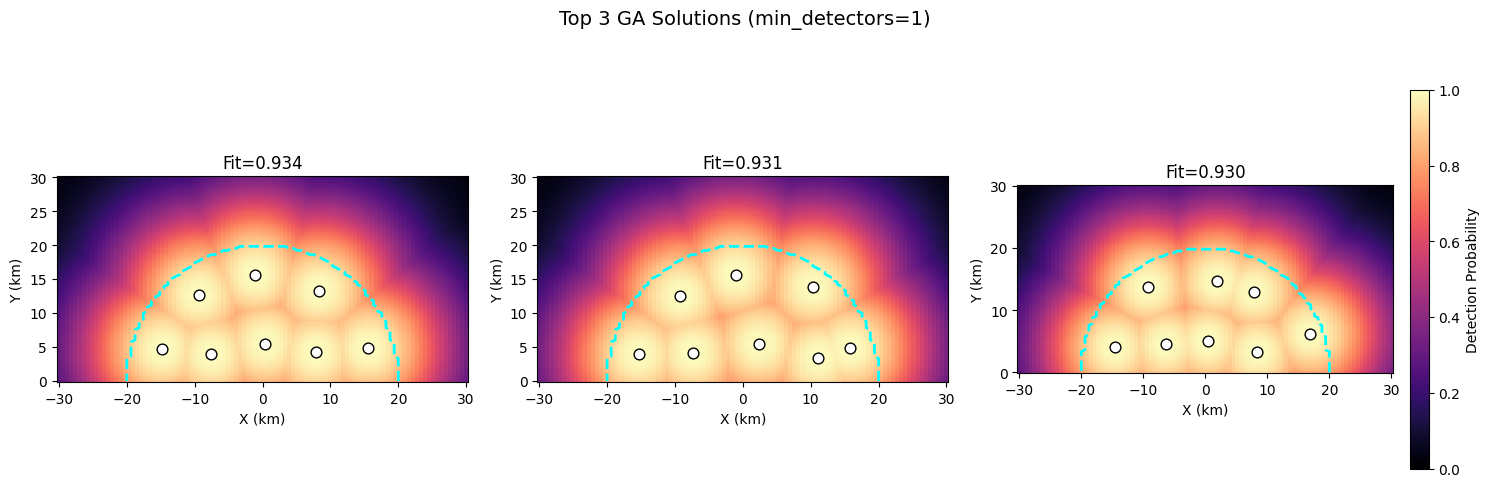


Multi-detector: Mean of top-4 detectors
Gen 01 | Mean=0.6584 | Best=0.7114 | Stag=0
Gen 02 | Mean=0.6998 | Best=0.7281 | Stag=0
Gen 03 | Mean=0.7059 | Best=0.7330 | Stag=0
Gen 04 | Mean=0.7245 | Best=0.7404 | Stag=0
Gen 05 | Mean=0.7334 | Best=0.7404 | Stag=1
Gen 06 | Mean=0.7268 | Best=0.7441 | Stag=0
Gen 07 | Mean=0.7321 | Best=0.7441 | Stag=1
Gen 08 | Mean=0.7284 | Best=0.7445 | Stag=0
Gen 09 | Mean=0.7290 | Best=0.7445 | Stag=1
Gen 10 | Mean=0.7367 | Best=0.7454 | Stag=0
Gen 11 | Mean=0.7332 | Best=0.7462 | Stag=0
Gen 12 | Mean=0.7358 | Best=0.7482 | Stag=0
Gen 13 | Mean=0.7355 | Best=0.7486 | Stag=0
Gen 14 | Mean=0.7286 | Best=0.7503 | Stag=0
Gen 15 | Mean=0.7435 | Best=0.7503 | Stag=1
Gen 16 | Mean=0.7362 | Best=0.7563 | Stag=0
Gen 17 | Mean=0.7387 | Best=0.7563 | Stag=1
Gen 18 | Mean=0.7446 | Best=0.7563 | Stag=2
Gen 19 | Mean=0.7466 | Best=0.7563 | Stag=3
Gen 20 | Mean=0.7455 | Best=0.7563 | Stag=4
Gen 21 | Mean=0.7451 | Best=0.7563 | Stag=5
Gen 22 | Mean=0.7433 | Best=0.7566 

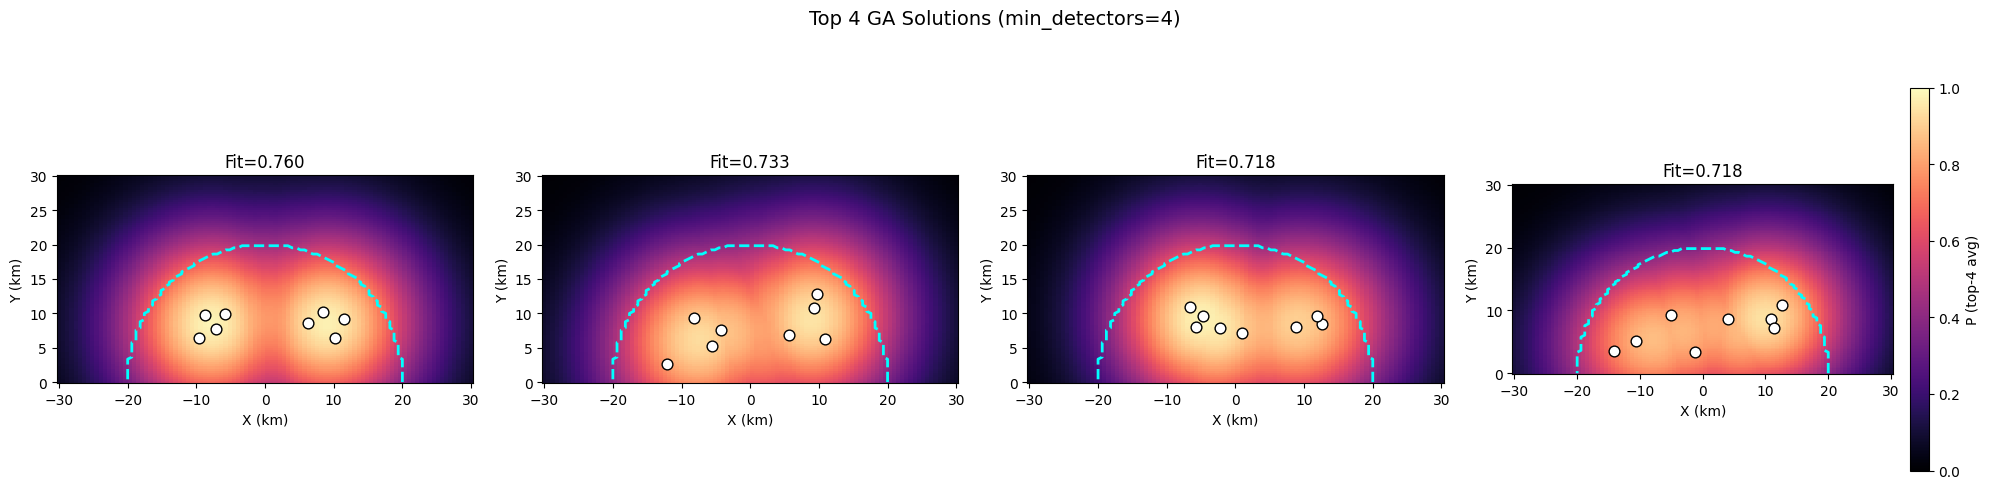

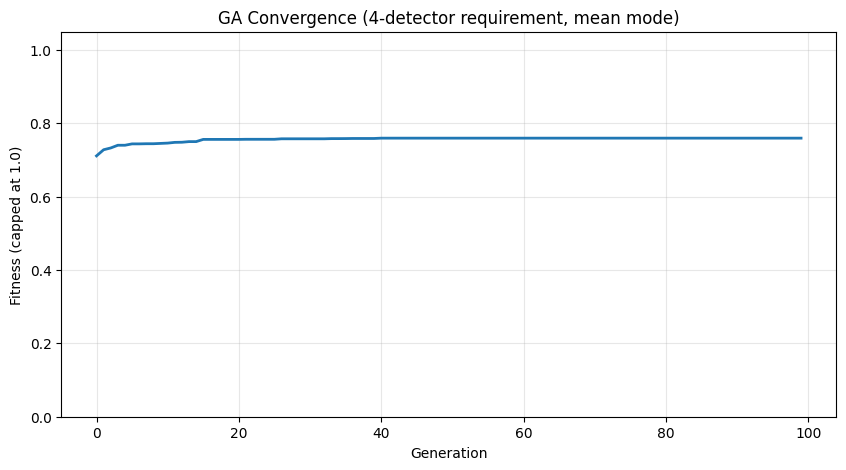

In [ ]:
if __name__ == "__main__":
    xlim, ylim = (-30, 30), (0, 30)
    grid_x = np.linspace(*xlim, 100)
    grid_y = np.linspace(*ylim, 100)
    sd = 10.0
    det_func = lambda d: half_normal(d, sd)
    mask = semicircle_mask(grid_x, grid_y, radius=20.0)

    # Example 1: Single detector (baseline - should get ~0.9)
    print("=" * 60)
    print("Baseline: Single detector requirement")
    print("=" * 60)
    env_baseline = Environment(
        grid_x, grid_y, det_func, mask,
        generations=50,
        num_recorders=8,
        metric='mean',
        min_detectors=1,
        initial_strategy='optimized_semicircle',
        initial_radius=20.0,
        mutation_rate=0.3,
        empty_penalty_fraction=0.8,
        close_penalty_fraction=0.2,
        min_dist=3.0
    )
    best_baseline, _ = env_baseline.run(k_top=3)

    # Example 2: Multi-detector with MEAN mode (recommended)
    print("\n" + "=" * 60)
    print("Multi-detector: Mean of top-4 detectors")
    print("=" * 60)
    env_multi = Environment(
        grid_x, grid_y, det_func, mask,
        generations=100,
        num_recorders=8,
        metric='mean',
        min_detectors=4,
        multi_detector_mode='mean',  # Average of top-4
        initial_strategy='optimized_semicircle',
        initial_radius=20.0,
        mutation_rate=0.25,
        mutation_std=2.0,
        empty_penalty_fraction=0.3,
        close_penalty_fraction=0.15,
        min_dist=2.5,  # Allow some overlap
        stagnation_limit=15
    )
    best_multi, scores = env_multi.run(k_top=4)

    # Plot convergence
    plt.figure(figsize=(10, 5))
    plt.plot(scores, linewidth=2)
    plt.xlabel('Generation')
    plt.ylabel('Fitness (capped at 1.0)')
    plt.title('GA Convergence (4-detector requirement, mean mode)')
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1.05])
    plt.show()